In [5]:
import random
import numpy as np
import torch


In [6]:
from main_ae import AgeModel
from main_ae import START_AGE, END_AGE, NUM_AGE_GROUPS


In [7]:
NUM_AGE_GROUPS = 9
VALIDATION_RATE = 0.1
num_ages = END_AGE - START_AGE + 1


In [8]:
random.seed(2019)
np.random.seed(2019)
torch.manual_seed(2019)


# AIHub dataset


In [9]:
import json
import pandas as pd

In [64]:
from fpt.data import join_face_df
from fpt.path import DTFR

DATA_CATEGORY = "aihub_family"
face_df = join_face_df(DTFR, DATA_CATEGORY)

In [65]:
# Age
age_df = pd.read_csv("/home/jupyter/data/dataframe/df_aihub_ages.csv", index_col=0)
face_df = face_df.join(age_df, on="target")

# Age group
ages = face_df[face_df.category == "Age"]
age_group_df = ages.key.str.split('_').map(lambda x: x[-1][0]).to_frame(name="age_group")
face_df = face_df.join(age_group_df)

# Update age
face_df.loc[age_group_df.index, "age"] = None

In [66]:
RANGE_TO_MEDIAN = {
    "a": (1 + 6) / 2,
    "b": (7 + 12) / 2,
    "c": (13 + 19) / 2,
    "d": (20 + 30) / 2,
    "e": (31 + 45) / 2,
    "f": (46 + 55) / 2,
    "g": (56 + 66) / 2,
    "h": (67 + 80) / 2,
    "above": 90,
}
AGE_GROUPS = ["a", "b", "c", "d", "e", "f", "g", "h", "above"]


def age_to_age_groups(age):
    if age <= 6:
        return "a"
    if age <= 12:
        return "b"
    if age <= 19:
        return "c"
    if age <= 30:
        return "d"
    if age <= 45:
        return "e"
    if age <= 55:
        return "f"
    if age <= 66:
        return "g"
    if age <= 80:
        return "h"
    return "above"

In [67]:
# age
is_age_null = face_df['age'].isnull()
range_to_age = face_df.loc[is_age_null, 'age_group'].map(lambda x: RANGE_TO_MEDIAN[x])
face_df.loc[is_age_null, 'age'] = range_to_age

In [69]:
# age group
is_age_group_null = face_df['age_group'].isnull()
age_groups = face_df.loc[is_age_group_null, 'age'].map(lambda x: age_to_age_groups(int(x)))
face_df.loc[is_age_group_null, 'age_group'] = age_groups

In [71]:
face_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109468 entries, 391fc9e5-eadd-4896-ab0c-61dffd9ab09c to afb1179b-d620-43c0-bad2-3660d9d73d60
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   key            109468 non-null  object 
 1   label          109468 non-null  object 
 2   image          109468 non-null  object 
 3   category       109468 non-null  object 
 4   option         109456 non-null  float64
 5   data_category  109468 non-null  object 
 6   folder_name    109468 non-null  object 
 7   family_id      109468 non-null  object 
 8   personal_id    109468 non-null  object 
 9   path           109468 non-null  object 
 10  target         109468 non-null  object 
 11  age            109468 non-null  float64
 12  age_group      109468 non-null  object 
dtypes: float64(2), object(11)
memory usage: 15.7+ MB


# Model


In [ ]:
model = AgeModel(num_ages, NUM_AGE_GROUPS)  # age_pred, age_group_pred

# Dataloader


In [17]:
from data import NiaDataset
import numpy as np
from PIL import Image
import os


In [18]:
from torch.utils.data import Dataset, DataLoader
import torchvision


In [19]:
train_meta_path = "nia_cropped/train_0.npy"
test_meta_path = "nia_cropped/test_0.npy"


In [20]:
batch_size = 16


## NiaDataset


### Train dataloader


In [21]:
transforms_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomApply(
            [
                torchvision.transforms.RandomAffine(degrees=10, shear=16),
                torchvision.transforms.RandomHorizontalFlip(p=1.0),
            ],
            p=0.5,
        ),
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.RandomCrop((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)


In [22]:
train_gen = NiaDataset(train_meta_path, transforms_train)


In [23]:
train_loader = DataLoader(
    dataset=train_gen,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)


In [24]:
train_iter = iter(train_loader)


In [25]:
sample = next(train_iter)
sample.keys()


dict_keys(['image', 'age', 'age_class', 'file', 'data_type', 'family_id', 'personal_id'])

In [26]:
for key in sample.keys():
    print(f"{key}:\t{sample[key][0]}")

image:	tensor([[[0.8627, 0.8627, 0.8627,  ..., 0.0784, 0.0824, 0.0863],
         [0.8627, 0.8667, 0.8667,  ..., 0.0902, 0.0902, 0.0902],
         [0.8627, 0.8667, 0.8706,  ..., 0.0980, 0.0941, 0.0863],
         ...,
         [0.8588, 0.8549, 0.8510,  ..., 0.5373, 0.5294, 0.5216],
         [0.8627, 0.8588, 0.8549,  ..., 0.5333, 0.5294, 0.5255],
         [0.8549, 0.8510, 0.8510,  ..., 0.5373, 0.5333, 0.5294]],

        [[0.8353, 0.8314, 0.8275,  ..., 0.0627, 0.0627, 0.0667],
         [0.8353, 0.8314, 0.8314,  ..., 0.0706, 0.0706, 0.0706],
         [0.8353, 0.8353, 0.8353,  ..., 0.0784, 0.0745, 0.0667],
         ...,
         [0.8235, 0.8235, 0.8235,  ..., 0.2980, 0.2902, 0.2824],
         [0.8314, 0.8275, 0.8275,  ..., 0.2941, 0.2902, 0.2863],
         [0.8235, 0.8196, 0.8235,  ..., 0.2980, 0.2941, 0.2902]],

        [[0.8000, 0.8000, 0.8000,  ..., 0.0510, 0.0549, 0.0588],
         [0.8039, 0.8039, 0.8039,  ..., 0.0588, 0.0588, 0.0588],
         [0.8039, 0.8078, 0.8078,  ..., 0.0667, 0.0

In [27]:
face_df.key

uuid
391fc9e5-eadd-4896-ab0c-61dffd9ab09c        F0001_AGE_D_18_a1
bf42518e-8415-4247-820f-77439018f31d        F0001_AGE_D_18_a2
98f0b57c-7a24-423f-b77c-82ed5719c6f4        F0001_AGE_D_18_a3
18779095-36e6-4b5d-8181-7a3860c8f012        F0001_AGE_D_18_a4
5d7928c2-72f8-412c-8762-835abaea8b00        F0001_AGE_D_18_b1
                                                ...          
949028f3-9157-4800-8e52-31a5c85a875c    F0900_IND_M_57_-90_02
377e54be-0e2f-4a27-8bf3-92b29ea68cad    F0900_IND_M_57_-45_02
91e72b0c-2d49-45ae-a208-b7d26e658c14      F0900_IND_M_57_0_02
a5fa8816-5d76-41d3-a32a-69c691bc18e9     F0900_IND_M_57_45_02
afb1179b-d620-43c0-bad2-3660d9d73d60     F0900_IND_M_57_90_02
Name: key, Length: 109468, dtype: object

In [28]:
idx = 1
file_name, _ = os.path.splitext(sample['file'][idx])
file_name in face_df.key

False

### Validation dataloader


In [29]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)
val_gen = NiaDataset(test_meta_path, transforms)
val_loader = DataLoader(
    val_gen, batch_size=1, shuffle=False, pin_memory=True, num_workers=0
)


# Optimizer


In [ ]:
from torch import optim
import torch
from torch.optim import lr_scheduler


In [ ]:
LAMBDA_1 = 0.2
LAMBDA_2 = 0.05
START_AGE = 0
END_AGE = 90
learning_rate = 1e-3
epoch = 2


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8, 9], gamma=0.1)


# Loss function


In [ ]:
from mean_variance_loss import MeanVarianceLoss


In [ ]:
criterion1 = MeanVarianceLoss(LAMBDA_1, LAMBDA_2, START_AGE, END_AGE).cuda
criterion2 = torch.nn.CrossEntropyLoss().cuda()


# Train


In [ ]:
from main_ae import train_softmax, evaluate_softmax


In [ ]:
def train_softmax(train_loader, model, criterion2, optimizer, epoch, result_directory):
    model.cuda().train()
    running_loss = 0.0
    running_softmax_loss = 0.0
    interval = 1
    for i, sample in enumerate(train_loader):
        images = sample["image"].cuda()
        labels = sample["age_class"].cuda()
        _, output = model(images)
        loss = criterion2(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        if (i + 1) % interval == 0:
            print("[%d, %5d] loss: %.3f" % (epoch, i, running_loss / interval))
            with open(os.path.join(result_directory, "log"), "a") as f:
                f.write("[%d, %5d] loss: %.3f\n" % (epoch, i, running_loss / interval))
            running_loss = 0.0


In [ ]:
for epoch in range(2):
    break
    train_softmax(train_loader, model, criterion2, optimizer, epoch, "result")
    loss_val, mae = evaluate_softmax(val_loader, model, criterion2)
    scheduler.step()


In [ ]:
# loss_val, mae


# Custom


In [ ]:
from torch import nn
from nia_age.main_ae import Embedding, AgeClassifier


In [ ]:
model = nn.Sequential(Embedding(), AgeClassifier(num_ages, NUM_AGE_GROUPS))
model = model.cuda()


In [ ]:
images = sample["image"]
images = images.cuda()


In [ ]:
pred_age, pred_age_group = model(images)
pred_age.shape, pred_age_group.shape


## Face Recognition


In [ ]:
from arcface_torch.losses import CombinedMarginLoss
from arcface_torch.configs.aihub_r50_onegpu import config as aihub_config
from arcface_torch.configs.base import config as cfg

cfg.update(aihub_config)
cfg.output = "work_dirs/aihub_r50_onegpu"

In [ ]:
margin_loss = CombinedMarginLoss(
    64,
    cfg.margin_list[0],
    cfg.margin_list[1],
    cfg.margin_list[2],
    cfg.interclass_filtering_threshold,
)

## AIHubDataset

In [30]:
from facenet.datasets.AIHubDataset import AIHubDataset
from torchvision.datasets import ImageFolder

In [32]:
root_dir = '/home/jupyter/data/face-image/train_aihub_family'
image_size = 112
aihub_mean = [0.5444, 0.4335, 0.3800]
aihub_std = [0.2672, 0.2295, 0.2156]
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(image_size, image_size)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=aihub_mean, std=aihub_std),
    ]
)

In [33]:
train_set = ImageFolder(root_dir, transform)
next(iter(train_set))

(tensor([[[ 1.4849e+00,  1.4996e+00,  1.4996e+00,  ...,  1.4849e+00,
            1.4996e+00,  1.4849e+00],
          [ 1.4996e+00,  1.4996e+00,  1.5143e+00,  ...,  1.4849e+00,
            1.4849e+00,  1.4996e+00],
          [ 1.5290e+00,  1.5290e+00,  1.5436e+00,  ...,  1.5143e+00,
            1.5143e+00,  1.5290e+00],
          ...,
          [-7.0770e-02, -3.2027e-01, -3.9365e-01,  ..., -7.8992e-01,
            4.5759e-01,  5.8967e-01],
          [ 1.7289e-02, -1.5883e-01, -7.0770e-02,  ..., -8.1927e-01,
            3.1082e-01,  5.7500e-01],
          [ 2.6126e-03,  1.7289e-02, -7.0770e-02,  ..., -9.0733e-01,
            1.3470e-01,  3.9888e-01]],
 
         [[ 2.2463e+00,  2.2634e+00,  2.2804e+00,  ...,  2.2463e+00,
            2.2634e+00,  2.2463e+00],
          [ 2.2634e+00,  2.2634e+00,  2.2804e+00,  ...,  2.2463e+00,
            2.2463e+00,  2.2634e+00],
          [ 2.2804e+00,  2.2975e+00,  2.2975e+00,  ...,  2.2634e+00,
            2.2804e+00,  2.2804e+00],
          ...,
    

## Multi task Dataset


In [34]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from easydict import EasyDict as edict

In [35]:
class FaceAgeDataset(Dataset):
    def __init__(self, root_dir, face_df, transform=None):
        self.face_dataset = ImageFolder(root=root_dir, transform=transform)
        self.face_df = face_df
        self.class_to_idx = self.face_dataset.class_to_idx

    def __len__(self):
        return len(self.face_dataset)

    def __getitem__(self, index):
        image, face_label = self.face_dataset[index]
        path, _ = self.face_dataset.samples[index]
        *_, key = os.path.splitext(path)[0].split("/")
        row = self.face_df.loc[key]
        age, age_group = row.age, row.age_group
        family_id, target = row.family_id, row.target
        sample = edict({
            "image": image,
            "age": age,
            "age_class": age_group,
            "file": path,
            "data_type": None,
            "family_id": family_id,
            "personal_id": self.class_to_idx[target],
            "key": key,
        })

        return sample

In [72]:
root_dir = "/home/jupyter/data/face-image/train_aihub_family"
face_age_dataset = FaceAgeDataset(root_dir, face_df)
iterator = iter(face_age_dataset)

image: <PIL.Image.Image image mode=RGB size=783x783 at 0x7F703C9944D0>
age: 75.0
age_class: h
file: /home/jupyter/data/face-image/train_aihub_family/F0001-GM/d2e77ffa-8278-46a0-9f23-ffad8abcca7d.jpg
data_type: None
family_id: F0001
personal_id: 1
key: d2e77ffa-8278-46a0-9f23-ffad8abcca7d


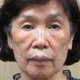

In [167]:
sample = next(iterator)
[print(f"{k}: {v}") for k, v in sample.items()]
sample.image.resize((80, 80))

## Face Recognition loss


In [ ]:
from torch.nn.functional import linear, normalize


In [ ]:
labels = labels.view(-1, 1)
norm_embeddings = normalize(embeddings)
norm_weight_activated = normalize(weight)
logits = linear(norm_embeddings, norm_weight_activated)
logits = logits.clamp(-1, 1)
